# Train a Neural ODE with Optax

We can use the parameter estimation functionality to fit a neural ODE to a time series data set.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import dense_output, solution_routines, solvers
from probdiffeq.doc_util import notebook
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

To keep the problem nice and small, assume that the data set is a trigonometric function (which solve differential equations).

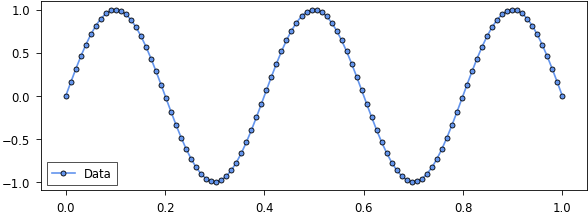

In [3]:
grid = jnp.linspace(0, 1, num=100)
data = jnp.sin(5 * jnp.pi * grid)

plt.plot(grid, data, ".-", label="Data")
plt.legend()
plt.show()

In [4]:
def build_loss_fn(vf, initial_values, obs_stdev=1e-2):
    """Build a loss function from an ODE problem."""

    @jax.jit
    def loss_fn(parameters):
        sol = solution_routines.solve_fixed_grid(
            vf,
            initial_values=initial_values,
            grid=grid,
            solver=solver,
            parameters=parameters,
        )

        observation_std = jnp.ones_like(grid) * obs_stdev
        return dense_output.negative_marginal_log_likelihood(
            observation_std=observation_std, u=data, solution=sol
        )

    return loss_fn

In [5]:
def build_update_fn(*, optimizer, loss_fn):
    """Build a function for executing a single step in the optimization."""

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    return update

## Construct an MLP with tanh activation

Let's start with the example given in the [implicit layers tutorial](http://implicit-layers-tutorial.org/neural_odes/). The vector field is provided by [DiffEqZoo](https://diffeqzoo.readthedocs.io/).

In [6]:
f, u0, (t0, t1), f_args = ivps.neural_ode_mlp(layer_sizes=(2, 20, 1))


@jax.jit
def vf(y, *, t, p):
    return f(y, t, *p)


# Make a solver
strategy = smoothers.Smoother(
    recipes.IsoTS0.from_params(num_derivatives=1),
)
solver = solvers.CalibrationFreeSolver(strategy, output_scale_sqrtm=1.0)

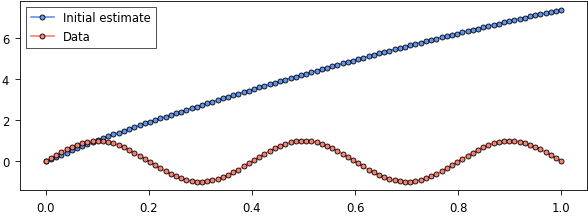

In [7]:
sol = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0,), grid=grid, solver=solver, parameters=f_args
)

plt.plot(sol.t, sol.u, ".-", label="Initial estimate")
plt.plot(grid, data, ".-", label="Data")
plt.legend()
plt.show()

## Set up a loss function and an optimiser

Like in the other tutorials, we use [Optax](https://optax.readthedocs.io/en/latest/index.html).

In [8]:
loss_fn = build_loss_fn(vf=vf, initial_values=(u0,))
optim = optax.adam(learning_rate=1e-2)
update_fn = build_update_fn(optimizer=optim, loss_fn=loss_fn)

In [9]:
p = f_args
state = optim.init(p)

chunk_size = 30
for i in range(chunk_size):
    for _ in range(chunk_size**2):
        p, state = update_fn(p, state)
    print(f"After {(i+1)*chunk_size**2}/{chunk_size**3} steps:", loss_fn(p))

After 900/27000 steps: 2217.5250353432157
After 1800/27000 steps: 1849.6786549111664
After 2700/27000 steps: 1696.4549931979395
After 3600/27000 steps: 1594.177372408777
After 4500/27000 steps: 1524.2940072076892
After 5400/27000 steps: 1475.7819221328666
After 6300/27000 steps: 1436.7945427959585
After 7200/27000 steps: 1402.7793560567227
After 8100/27000 steps: 1371.6999029707424
After 9000/27000 steps: 1342.4422959178871
After 9900/27000 steps: 1314.1876092027983
After 10800/27000 steps: 1286.078516666898
After 11700/27000 steps: 1255.012274469376
After 12600/27000 steps: 1224.671701127862
After 13500/27000 steps: 1186.4342401447277
After 14400/27000 steps: 1134.034547707536
After 15300/27000 steps: 1059.4327641318296
After 16200/27000 steps: 1030.6539810600846
After 17100/27000 steps: 961.1434221368717
After 18000/27000 steps: 885.6679236302284
After 18900/27000 steps: 748.4370474100984
After 19800/27000 steps: 484.85488209327946
After 20700/27000 steps: 155.96751079047095
After 21

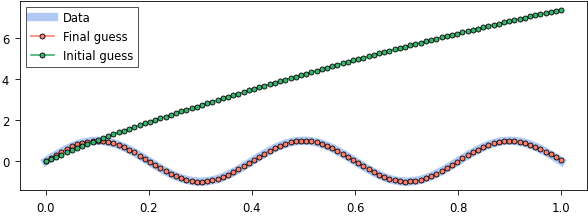

In [10]:
plt.plot(sol.t, data, "-", linewidth=5, alpha=0.5, label="Data")


sol = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0,), grid=grid, solver=solver, parameters=p
)
plt.plot(sol.t, sol.u, ".-", label="Final guess")

sol = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0,), grid=grid, solver=solver, parameters=f_args
)
plt.plot(sol.t, sol.u, ".-", label="Initial guess")


plt.legend()
plt.show()

## What's next


The same example can be constructed with deep learning libraries such as [Equinox](https://docs.kidger.site/equinox/), [Haiku](https://dm-haiku.readthedocs.io/en/latest/), or [Flax](https://flax.readthedocs.io/en/latest/getting_started.html).
To do so, define a corresponding vector field and a parameter set, build a new loss function and repeat.

